# Car Evaluation Project

## Structure
1. **DATA PREPARATION & DATA CLEANING**
    - Load and Inspect Dataset
    - Correct Data Types
    - Encode Features Properly
    - Encode Target
    - Handle Class Imbalance
2. **EDA & FEATURE IMPORTANCE ANALYSIS**
    - Univariate Analysis
    - Bivariate Analysis
    - Correlation Structure
    - Feature Importance
3. **MODEL SELECTION & PARAMETER TUNING**
    - Base Models to Train
    - Evaluation Protocol
    - Hyperparameter Search
    - Select Best Model

### Importing Libraries
This cell imports all the necessary libraries for the project. 
It includes libraries for data manipulation (`pandas`, `numpy`), data visualization (`matplotlib`, `seaborn`), 
and machine learning (`scikit-learn`, `xgboost`). 
It also sets some configurations for warnings and plot styles.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
import xgboost as xgb
import joblib

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")

# `1. DATA PREPARATION & DATA CLEANING`

## `1.1 Load and Inspect Dataset`

### Loading the Dataset
This cell loads the car evaluation dataset from a CSV file into a pandas DataFrame. 
It also assigns meaningful column names to the dataset. 
Finally, it prints the shape of the DataFrame, the number of missing values, and the data types of each column, and displays the first 5 rows of the data.

In [5]:
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv('dataset/car.csv', names=columns)

print(f"Shape: {df.shape}")
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)

df.head()

Shape: (1728, 7)

Missing Values:
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Data Types:
buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Checking Unique Values
This cell iterates through each column of the DataFrame and prints the unique values. 
This is an important step to understand the categorical nature of the features and to identify any potential data entry errors.

In [6]:
# Check unique values
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

buying: ['vhigh' 'high' 'med' 'low']
maint: ['vhigh' 'high' 'med' 'low']
doors: ['2' '3' '4' '5more']
persons: ['2' '4' 'more']
lug_boot: ['small' 'med' 'big']
safety: ['low' 'med' 'high']
class: ['unacc' 'acc' 'vgood' 'good']


## ```1.2 & 1.3 Encode Features```
- **Ordinal**: buying, maint, doors, persons, safety
- **Nominal**: lug_boot (One-Hot)
- **Target**: class 


### Encoding Categorical Features
This cell performs the encoding of categorical features. 
It uses manual mapping for ordinal features to preserve the order of the categories. 
For the 'lug_boot' feature, it uses one-hot encoding to convert the categorical data into a numerical format. 
Finally, it encodes the target variable 'class' into numerical values.

In [7]:
# Manual Mapping for Ordinal Features to preserve specific order
ordinal_mappings = {
    'buying': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'maint': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

df_encoded = df.copy()

for col, mapping in ordinal_mappings.items():
    df_encoded[col] = df_encoded[col].map(mapping)

# One-Hot Encoding for 'lug_boot'
df_encoded = pd.get_dummies(df_encoded, columns=['lug_boot'], drop_first=False)

# Target Encoding
class_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
df_encoded['class'] = df_encoded['class'].map(class_mapping)

print("Encoded Dataset Head:")
df_encoded.head()

Encoded Dataset Head:


,buying,maint,doors,persons,safety,class,lug_boot_big,lug_boot_med,lug_boot_small
0,3,3,0,0,0,0,False,False,True
1,3,3,0,0,1,0,False,False,True
2,3,3,0,0,2,0,False,False,True
3,3,3,0,0,0,0,False,True,False
4,3,3,0,0,1,0,False,True,False


## `1.5 Handle Class Imbalance`

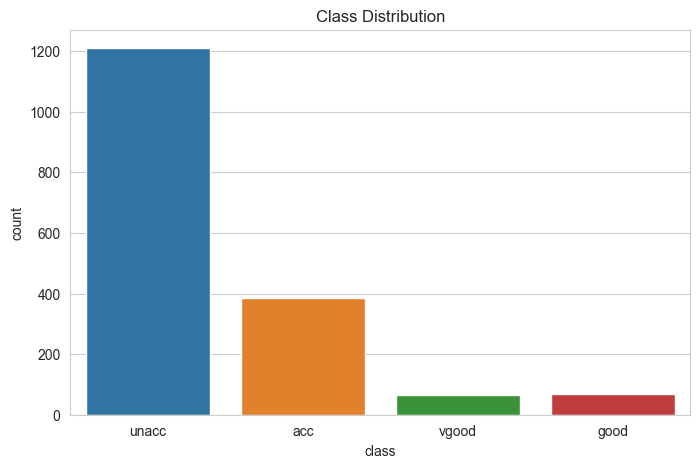

class
unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

print(df['class'].value_counts(normalize=True))

**Strategy**: We will use **Class Weights** in our models to handle the imbalance, as oversampling might introduce noise or overfitting in this small dataset.

# 2. EDA & FEATURE IMPORTANCE ANALYSIS

## 2.1 Univariate & 2.2 Bivariate Analysis

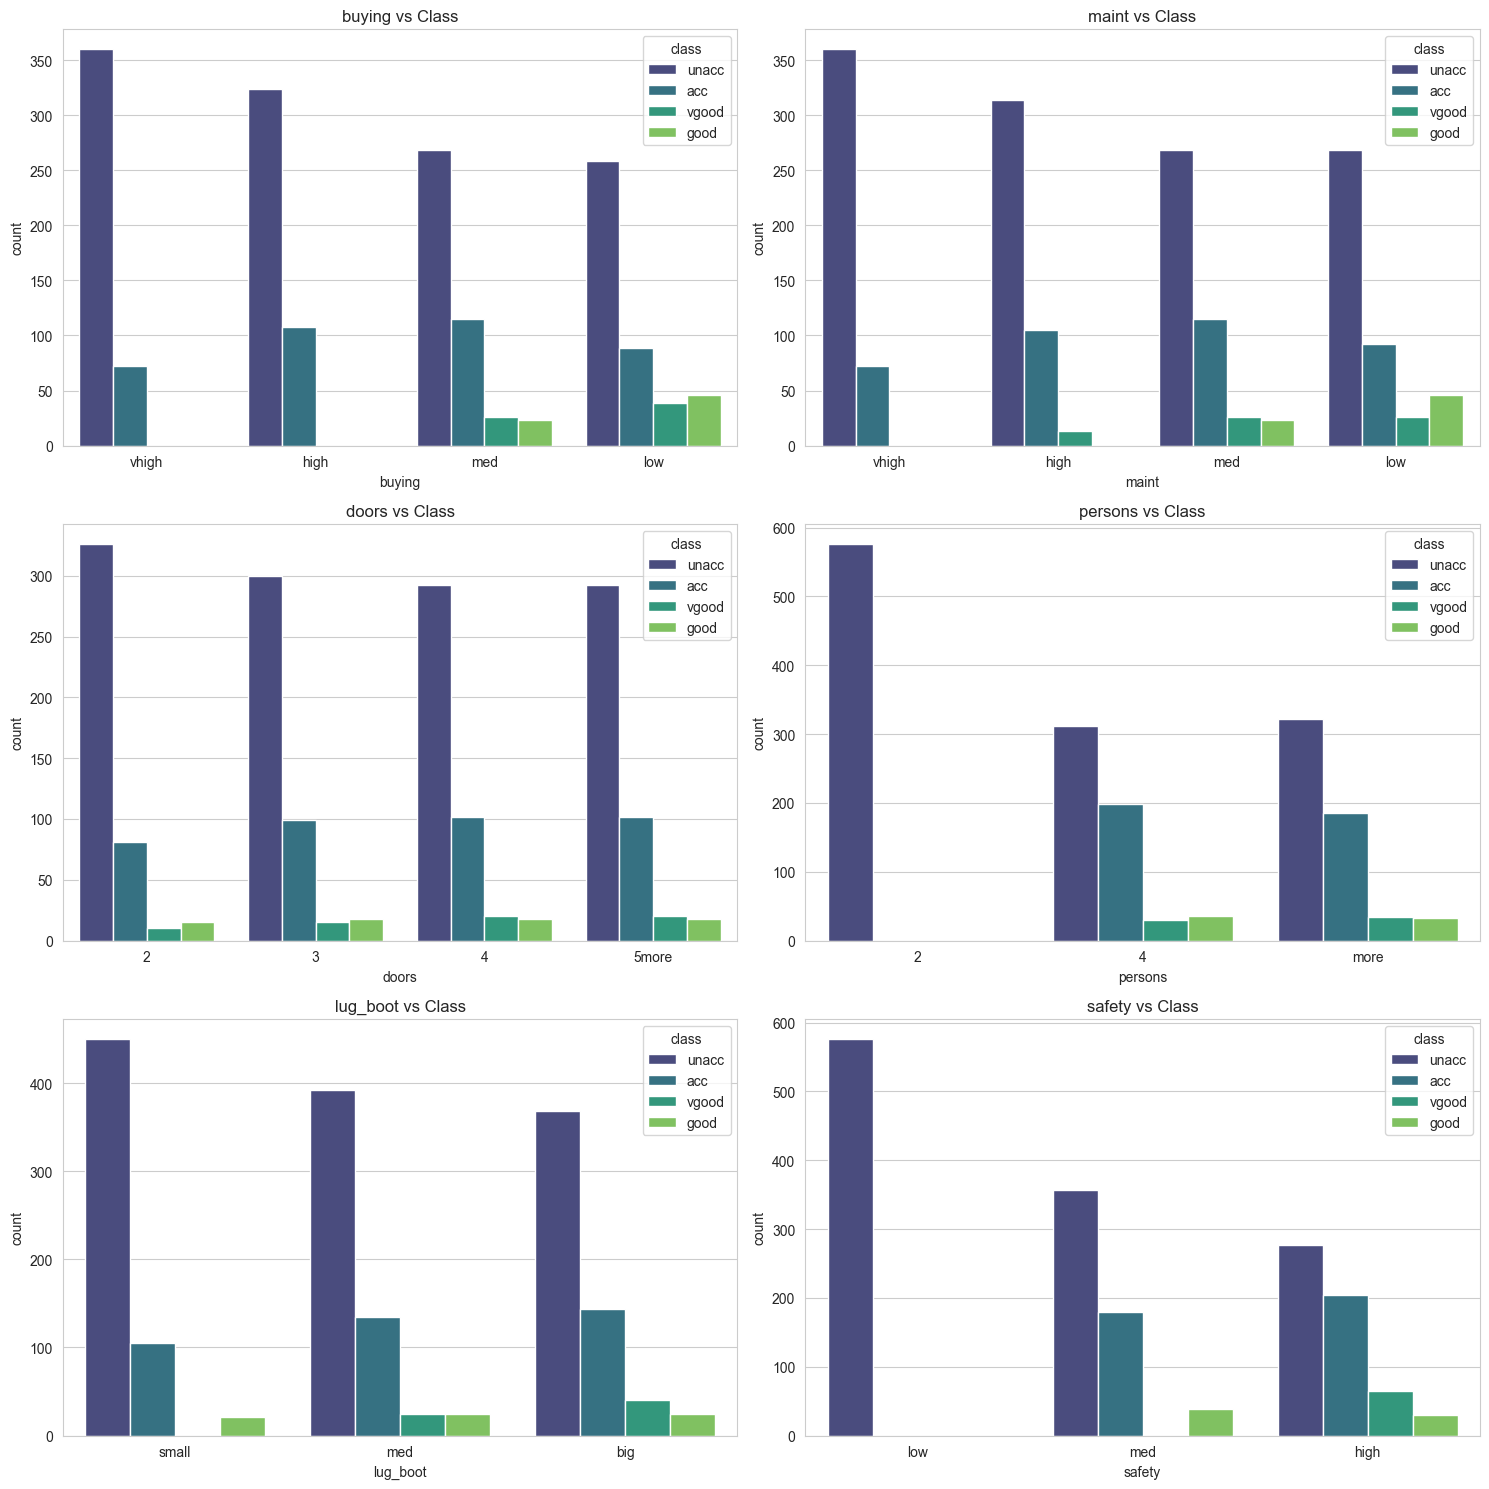

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
categorical_cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='class', data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{col} vs Class')

plt.tight_layout()
plt.show()


## 2.3 Correlation Structure (Cramer's V)

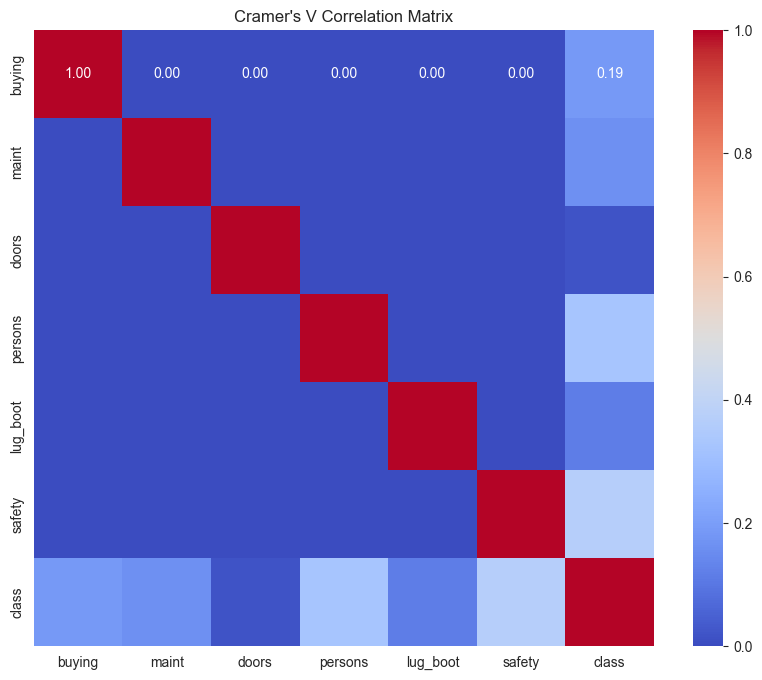

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
corr_matrix = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramer's V Correlation Matrix")
plt.show()

## 2.4 Feature Importance

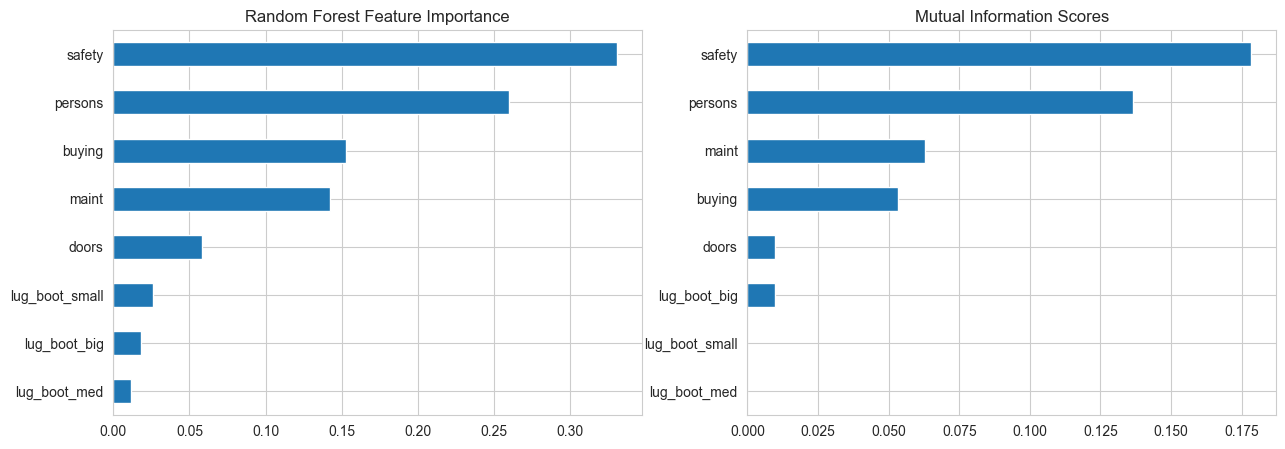

In [12]:
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# 1. Random Forest Importance
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X, y)
rf_imp = pd.Series(rf_temp.feature_importances_, index=X.columns)

# 2. Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_imp = pd.Series(mi_scores, index=X.columns)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

rf_imp.sort_values().plot(kind='barh', ax=ax[0], title='Random Forest Feature Importance')
mi_imp.sort_values().plot(kind='barh', ax=ax[1], title='Mutual Information Scores')
plt.show()

# 3. MODEL SELECTION & PARAMETER TUNING

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE (Synthetic Minority Over-sampling Technique) only on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now train your model using X_train_resampled and y_train_resampled

# Define Models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Naive Bayes': GaussianNB()
}

try:
    models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
except NameError:
    pass

# Baseline Evaluation (Cross-Validation)
results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')
    results.append({'Model': name, 'Mean F1 Macro': cv_scores.mean(), 'Std': cv_scores.std()})

pd.DataFrame(results).sort_values(by='Mean F1 Macro', ascending=False)

,Model,Mean F1 Macro,Std
4,XGBoost,0.960199,0.023596
1,Random Forest,0.941666,0.031035
0,Decision Tree,0.939708,0.029227
2,Logistic Regression,0.725304,0.038984
3,Naive Bayes,0.489061,0.043193


## 3.3 Hyperparameter Search

### Hyperparameter Tuning (Random Forest)
This cell performs hyperparameter tuning for the Random Forest model using GridSearchCV. 
It searches for the best combination of hyperparameters from the `rf_params` dictionary. 
The best parameters and the best F1 macro score are then printed.

In [ ]:
# We will tune the top performing models (likely RF and XGB)

# Random Forest Grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train_resampled, y_train_resampled)

print(f"Best RF Params: {grid_rf.best_params_}")
print(f"Best RF Score: {grid_rf.best_score_}")

Best RF Params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Score: 0.9512856311835142


In [ ]:
# XGBoost Grid (if available)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 
                        xgb_params, cv=5, scoring='f1_macro', n_jobs=-1)
grid_xgb.fit(X_train_resampled, y_train_resampled)
print(f"Best XGB Params: {grid_xgb.best_params_}")
print(f"Best XGB Score: {grid_xgb.best_score_}")

Best XGB Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB Score: 0.9630512952234858


## 3.4 Select Best Model & Final Evaluation

Selected Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Classification Report:
              precision    recall  f1-score   support

       unacc       1.00      1.00      1.00       242
         acc       0.97      0.99      0.98        77
        good       1.00      

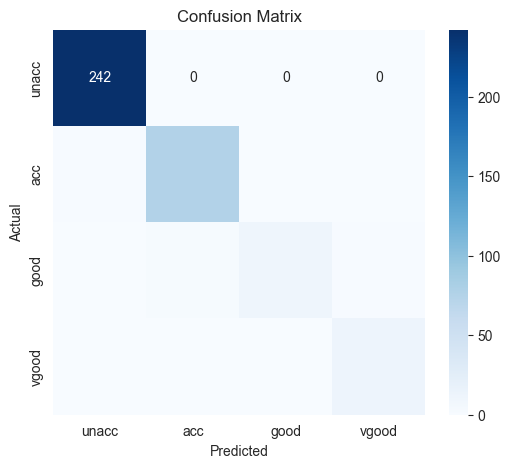

In [16]:
best_model = grid_rf.best_estimator_
# If XGBoost was better, use it:
if 'XGBoost' in models and grid_xgb.best_score_ > grid_rf.best_score_:
    best_model = grid_xgb.best_estimator_

print(f"Selected Model: {best_model}")

# Final Test Set Evaluation
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

print("\nConfusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Save Model
joblib.dump(best_model, 'best_model.pkl')
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb





def train():
    print("Loading data...")
    columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    df = pd.read_csv('dataset/car.csv', names=columns)

    print("Preprocessing...")
    X = df.drop('class', axis=1)
    y = df['class']

    ordinal_mappings = {
        'buying': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
        'maint': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
        'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
        'persons': {'2': 0, '4': 1, 'more': 2},
        'safety': {'low': 0, 'med': 1, 'high': 2}
    }

    for col, mapping in ordinal_mappings.items():
        X[col] = X[col].map(mapping)

    # One-Hot Encoding for 'lug_boot'
    X = pd.get_dummies(X, columns=['lug_boot'], drop_first=False)
    # Target Encoding
    class_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
    y = y.map(class_mapping)

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training models...")
    xgbooster = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
            
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }

    grid_search = GridSearchCV(xgbooster, xgb_params, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best Params: {grid_search.best_params_}")

    print("Evaluating...")
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))

    print("Saving model...")
    with open('model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Done.")

if __name__ == "__main__":
    train()


Loading data...
Preprocessing...
Training models...
